# U.S. Places

This notebook contains scripts that generate a dataset of U.S. places, like cities and towns, based on the data from the U.S. Census Bureau. The generated dataset has the following structure:

* `geo_id` - a unique identifier of the place in Census Bureau format.
* `name` - a name of the place.
* `lsad_code` - LSAD code of the place.
* `name_lsad` - a name of the place with its LSAD type.
* `state_abbr` - two-symbol USPS state abbreviation.
* `name_state` - a name of the place, including state abbreviation.
* `status` - functional status of the place.
* `area_land` - land area of the place.
* `area_water` - water area of the place.
* `area_total` - total area of the place.
* `lat` - the geographical latitude of the place.
* `lon` - the geographical longitude of the place.
* `pop_prev` - the population of the place, according to the previous census survey.
* `pop_last` - the population of the place, according to the latest census survey.
* `pop_est` - the current estimated place population.
* `pop_dod` - decade-over-decade population change (between previous and the latest census surveys).
* `pop_ltd` - last-to-date population change (between the latest census survey and current estimate).

The script generates the dataset in CSV and Shape formats. Result files are stored in the output directory, specified by the `OUTBOUND_PATH` constant.

In [1]:
'''
Notebook parameters.
'''

DOWNLOAD = False
GEODATA_YEAR = "2022"
GEODATA_BASE_URI = "https://www2.census.gov/geo/tiger"

POPULATION_SURVEYS_PREVIOUS_YEAR = "2010"
POPULATION_SURVEYS_BASE_YEAR = "2020"
POPULATION_SURVEYS_ESTIMATE_YEAR = "2021"
POPULATION_SURVEYS_BASE_URI = "https://www2.census.gov/programs-surveys/popest/datasets"

INBOUND_PATH = "../data/inbound/geo"
OUTBOUND_PATH = "../data/outbound/geo"

In [2]:
'''
Define U.S. regions.
'''

NEW_ENGLAND         = ["CT", "ME", "MA", "NH", "RI", "VT"]
MIDDLE_ATLANTIC     = ["NJ", "NY", "PA"]
EAST_NORTH_CENTRAL  = ["IN", "IL", "MI", "OH", "WI"]
WEST_NORTH_CENTRAL  = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
SOUTH_ATLANTIC      = ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]
EAST_SOUTH_CENTRAL  = ["AL", "KY", "MS", "TN"]
WEST_SOUTH_CENTRAL  = ["AR", "LA", "OK", "TX"]
MOUNTAIN            = ["AZ", "CO", "ID", "NM", "MT", "UT", "NV", "WY"]
PACIFIC             = ["CA", "OR", "WA"]
OCEAN               = ["AK", "HI"]

NORTHEAST           = NEW_ENGLAND + MIDDLE_ATLANTIC
MIDWEST             = EAST_NORTH_CENTRAL + WEST_NORTH_CENTRAL
SOUTH               = SOUTH_ATLANTIC + EAST_SOUTH_CENTRAL + WEST_SOUTH_CENTRAL
WEST                = MOUNTAIN + PACIFIC
CONTINENTAL         = NORTHEAST + MIDWEST + SOUTH + WEST

In [3]:
'''
Import dependencies.
'''

import os
import wget
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from urllib.error import HTTPError

In [4]:
'''
Initialize states dataframe.
'''

# load dataframe
states = gpd.read_file(OUTBOUND_PATH + "/us_states.shp.zip", compression="zip")

# normalize column types
states.fips_code = states.fips_code.astype("string")
states.usps_abbr = states.usps_abbr.astype("string")
states.name = states.name.astype("string")

states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   fips_code  56 non-null     string  
 1   usps_abbr  56 non-null     string  
 2   name       56 non-null     string  
 3   geometry   56 non-null     geometry
dtypes: geometry(1), string(3)
memory usage: 1.9 KB


In [5]:
'''
Download and initialize cities dataframe.
'''

def create_cities_df(state_id):
    
    '''
    Downloads a dataset of cities and towns for a given 
    state ID and creates a dataframe from it.
    '''
    
    filename = "tl_" + GEODATA_YEAR + "_" + state_id + "_place.zip"
    
    if DOWNLOAD:
        # download dataset
        source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/PLACE/" + filename
        dest = INBOUND_PATH + "/" + filename
        if os.path.exists(dest):
            os.remove(dest)
        wget.download(source, dest)
    
    # create dataframe
    return gpd.read_file(INBOUND_PATH + "/" + filename, compression="zip")

# concat dataframes from different files
cities = pd.concat((create_cities_df(state_id) for state_id in states["fips_code"]))

# drop unnecessary columns
cities.drop(
    [
        "PLACEFP", "PLACENS",
        "CLASSFP", "PCICBSA", "PCINECTA", 
        "MTFCC",
    ],
    axis=1,
    inplace=True,
)

# rename columns
cities.rename(
    columns={
        "GEOID": "geo_id",
        "STATEFP": "state_fips",
        "NAME": "name",
        "LSAD": "lsad_code",
        "NAMELSAD": "name_lsad",
        "FUNCSTAT": "status",
        "ALAND": "area_land",
        "AWATER": "area_water",
        "INTPTLAT": "lat",
        "INTPTLON": "lon",
    },
    inplace=True,
)

# normalize column types
cities.geo_id = cities.geo_id.astype("string")
cities.state_fips = cities.state_fips.astype("string")
cities.name = cities.name.astype("string")
cities.lsad_code = cities.lsad_code.astype("string")
cities.name_lsad = cities.name_lsad.astype("string")
cities.status = cities.status.astype("string")
cities.lat = cities.lat.map(np.float64)
cities.lon = cities.lon.map(np.float64)

cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 32466 entries, 0 to 466
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  32466 non-null  string  
 1   geo_id      32466 non-null  string  
 2   name        32466 non-null  string  
 3   name_lsad   32466 non-null  string  
 4   lsad_code   32466 non-null  string  
 5   status      32466 non-null  string  
 6   area_land   32466 non-null  int64   
 7   area_water  32466 non-null  int64   
 8   lat         32466 non-null  float64 
 9   lon         32466 non-null  float64 
 10  geometry    32466 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), string(6)
memory usage: 3.0 MB


In [6]:
'''
Download and initialize county subdivisions dataframe.
'''

def create_subdivisions_df(state_id):
    
    '''
    Downloads a dataset of county subdivisions for a 
    given state ID and creates a dataframe from it.
    '''
    
    filename = "tl_" + GEODATA_YEAR + "_" + state_id + "_cousub.zip"
    
    if DOWNLOAD:
        # download dataset
        source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/COUSUB/" + filename
        dest = INBOUND_PATH + "/" + filename
        if os.path.exists(dest):
            os.remove(dest)
        wget.download(source, dest)
    
    # create dataframe
    return gpd.read_file(INBOUND_PATH + "/" + filename, compression="zip")

# concat dataframes from different files
subdivisions = pd.concat((create_subdivisions_df(state_id) for state_id in states["fips_code"]))

# drop unnecessary columns
subdivisions.drop(
    [
        "COUNTYFP", "COUSUBFP", "COUSUBNS",
        "CLASSFP", "MTFCC",
        "CNECTAFP", "NECTAFP", "NCTADVFP",
    ],
    axis=1,
    inplace=True,
)

# rename columns
subdivisions.rename(
    columns={
        "GEOID": "geo_id",
        "STATEFP": "state_fips",
        "NAME": "name",
        "LSAD": "lsad_code",
        "NAMELSAD": "name_lsad",
        "FUNCSTAT": "status",
        "ALAND": "area_land",
        "AWATER": "area_water",
        "INTPTLAT": "lat",
        "INTPTLON": "lon",
    },
    inplace=True,
)

# normalize column types
subdivisions.geo_id = subdivisions.geo_id.astype("string")
subdivisions.state_fips = subdivisions.state_fips.astype("string")
subdivisions.name = subdivisions.name.astype("string")
subdivisions.lsad_code = subdivisions.lsad_code.astype("string")
subdivisions.name_lsad = subdivisions.name_lsad.astype("string")
subdivisions.status = subdivisions.status.astype("string")
subdivisions.lat = subdivisions.lat.map(np.float64)
subdivisions.lon = subdivisions.lon.map(np.float64)

subdivisions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 36600 entries, 0 to 79
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  36600 non-null  string  
 1   geo_id      36600 non-null  string  
 2   name        36600 non-null  string  
 3   name_lsad   36600 non-null  string  
 4   lsad_code   36600 non-null  string  
 5   status      36600 non-null  string  
 6   area_land   36600 non-null  int64   
 7   area_water  36600 non-null  int64   
 8   lat         36600 non-null  float64 
 9   lon         36600 non-null  float64 
 10  geometry    36600 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), string(6)
memory usage: 3.4 MB


In [7]:
'''
Download and initialize consolidated cities dataframe.
'''

def create_concities_df(state_id):
    
    '''
    Downloads a dataset of consolidated cities for a 
    given state ID and creates a dataframe from it.
    '''
    
    filename = "tl_" + GEODATA_YEAR + "_" + state_id + "_concity.zip"
    
    try:
        if DOWNLOAD:
            # download dataset
            source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/CONCITY/" + filename
            dest = INBOUND_PATH + "/" + filename
            if os.path.exists(dest):
                os.remove(dest)
            wget.download(source, dest)
        # create dataframe
        return gpd.read_file(INBOUND_PATH + "/" + filename, compression="zip")
    except:
        pass

# concat dataframes from different files
con_cities = pd.concat((create_concities_df(state_id) for state_id in states["fips_code"]))

# drop unnecessary columns
con_cities.drop(
    [
        "CONCTYFP", "CONCTYNS",
        "CLASSFP", "MTFCC"
    ],
    axis=1,
    inplace=True,
)

# rename columns
con_cities.rename(
    columns={
        "GEOID": "geo_id",
        "STATEFP": "state_fips",
        "NAME": "name",
        "LSAD": "lsad_code",
        "NAMELSAD": "name_lsad",
        "FUNCSTAT": "status",
        "ALAND": "area_land",
        "AWATER": "area_water",
        "INTPTLAT": "lat",
        "INTPTLON": "lon",
    },
    inplace=True,
)

# normalize column types
con_cities.geo_id = con_cities.geo_id.astype("string")
con_cities.state_fips = con_cities.state_fips.astype("string")
con_cities.name = con_cities.name.astype("string")
con_cities.lsad_code = con_cities.lsad_code.astype("string")
con_cities.name_lsad = con_cities.name_lsad.astype("string")
con_cities.status = con_cities.status.astype("string")
con_cities.lat = con_cities.lat.map(np.float64)
con_cities.lon = con_cities.lon.map(np.float64)

con_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8 entries, 0 to 0
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  8 non-null      string  
 1   geo_id      8 non-null      string  
 2   name        8 non-null      string  
 3   name_lsad   8 non-null      string  
 4   lsad_code   8 non-null      string  
 5   status      8 non-null      string  
 6   area_land   8 non-null      int64   
 7   area_water  8 non-null      int64   
 8   lat         8 non-null      float64 
 9   lon         8 non-null      float64 
 10  geometry    8 non-null      geometry
dtypes: float64(2), geometry(1), int64(2), string(6)
memory usage: 768.0 bytes


In [8]:
'''
Concatenate cities, county subdivisions and consolidated cities into a single places dataframe.
'''

places = pd.concat([cities, subdivisions, con_cities])

# calculate total area
places["area_total"] = places.area_land + places.area_water

# normalize column types
places.status = places.status.astype("string")

places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69074 entries, 0 to 0
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  69074 non-null  string  
 1   geo_id      69074 non-null  string  
 2   name        69074 non-null  string  
 3   name_lsad   69074 non-null  string  
 4   lsad_code   69074 non-null  string  
 5   status      69074 non-null  string  
 6   area_land   69074 non-null  int64   
 7   area_water  69074 non-null  int64   
 8   lat         69074 non-null  float64 
 9   lon         69074 non-null  float64 
 10  geometry    69074 non-null  geometry
 11  area_total  69074 non-null  int64   
dtypes: float64(2), geometry(1), int64(3), string(6)
memory usage: 6.9 MB


In [9]:
'''
Merge places and states.
'''

places = pd.merge(
    places, 
    states.drop(["name", "geometry"], axis=1).rename(columns={
        "fips_code": "state_fips",
        "usps_abbr": "state_abbr",
    }), 
    on="state_fips",
    how="left",
)

# drop unnecessary columns
places.drop(["state_fips"], axis=1, inplace=True)

# generate place name with state
places["name_state"] = (places.name + ", " + places.state_abbr).astype("string")

places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69074 entries, 0 to 69073
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geo_id      69074 non-null  string  
 1   name        69074 non-null  string  
 2   name_lsad   69074 non-null  string  
 3   lsad_code   69074 non-null  string  
 4   status      69074 non-null  string  
 5   area_land   69074 non-null  int64   
 6   area_water  69074 non-null  int64   
 7   lat         69074 non-null  float64 
 8   lon         69074 non-null  float64 
 9   geometry    69074 non-null  geometry
 10  area_total  69074 non-null  int64   
 11  state_abbr  69074 non-null  string  
 12  name_state  69074 non-null  string  
dtypes: float64(2), geometry(1), int64(3), string(7)
memory usage: 7.4 MB


In [10]:
'''
Download and initialize last population estimates dataframe.
'''

filename = "sub-est" + POPULATION_SURVEYS_ESTIMATE_YEAR + "_all" + ".csv"
source = POPULATION_SURVEYS_BASE_URI + "/" + POPULATION_SURVEYS_BASE_YEAR + "-" + POPULATION_SURVEYS_ESTIMATE_YEAR + "/cities/totals/" + filename
dest = INBOUND_PATH + "/" + filename

if DOWNLOAD:
    # download dataset
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
population = pd.read_csv(dest, encoding="ISO-8859-1")

# drop unnecessary columns
population = population[[
    "STATE",
    "COUNTY",
    "PLACE",
    "COUSUB",
    "CONCIT",
    "ESTIMATESBASE" + POPULATION_SURVEYS_BASE_YEAR,
    "POPESTIMATE" + POPULATION_SURVEYS_ESTIMATE_YEAR,
]]

# rename columns
population.rename(
    columns={
        "ESTIMATESBASE" + POPULATION_SURVEYS_BASE_YEAR: "pop_last",
        "POPESTIMATE" + POPULATION_SURVEYS_ESTIMATE_YEAR: "pop_est",
    },
    inplace=True,
)

# normalize column types
population.STATE = population.STATE.apply(lambda code: "{:02d}".format(code)).astype("string")
population.COUNTY = population.COUNTY.apply(lambda code: "{:03d}".format(code)).astype("string")
population.PLACE = population.PLACE.apply(lambda code: "{:05d}".format(code)).astype("string")
population.COUSUB = population.COUSUB.apply(lambda code: "{:05d}".format(code)).astype("string")
population.CONCIT = population.CONCIT.apply(lambda code: "{:05d}".format(code)).astype("string")

population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81416 entries, 0 to 81415
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STATE     81416 non-null  string
 1   COUNTY    81416 non-null  string
 2   PLACE     81416 non-null  string
 3   COUSUB    81416 non-null  string
 4   CONCIT    81416 non-null  string
 5   pop_last  81416 non-null  int64 
 6   pop_est   81416 non-null  int64 
dtypes: int64(2), string(5)
memory usage: 4.3 MB


In [11]:
'''
Download and initialize previous population survey dataframe.
'''

filename = "SUB-EST" + POPULATION_SURVEYS_BASE_YEAR + "_ALL" + ".csv"
source = POPULATION_SURVEYS_BASE_URI + "/" + POPULATION_SURVEYS_PREVIOUS_YEAR + "-" + POPULATION_SURVEYS_BASE_YEAR + "/cities/" + filename
dest = INBOUND_PATH + "/" + filename

if DOWNLOAD:
    # download dataset
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
previous_population = pd.read_csv(dest, encoding="ISO-8859-1")

# drop unnecessary columns
previous_population = previous_population[[
    "STATE",
    "COUNTY",
    "PLACE",
    "COUSUB",
    "CONCIT",
    "ESTIMATESBASE" + POPULATION_SURVEYS_PREVIOUS_YEAR,
]]

# rename columns
previous_population.rename(
    columns={
        "ESTIMATESBASE" + POPULATION_SURVEYS_PREVIOUS_YEAR: "pop_prev",
    },
    inplace=True,
)

# normalize column types
previous_population.STATE = previous_population.STATE.apply(lambda code: "{:02d}".format(code)).astype("string")
previous_population.COUNTY = previous_population.COUNTY.apply(lambda code: "{:03d}".format(code)).astype("string")
previous_population.PLACE = previous_population.PLACE.apply(lambda code: "{:05d}".format(code)).astype("string")
previous_population.COUSUB = previous_population.COUSUB.apply(lambda code: "{:05d}".format(code)).astype("string")
previous_population.CONCIT = previous_population.CONCIT.apply(lambda code: "{:05d}".format(code)).astype("string")

previous_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81415 entries, 0 to 81414
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STATE     81415 non-null  string
 1   COUNTY    81415 non-null  string
 2   PLACE     81415 non-null  string
 3   COUSUB    81415 non-null  string
 4   CONCIT    81415 non-null  string
 5   pop_prev  81415 non-null  int64 
dtypes: int64(1), string(5)
memory usage: 3.7 MB


In [12]:
'''
Merge current survey population dataframe with previous survey population dataframe
'''

population = pd.merge(
    population,
    previous_population,
    on=["STATE", "COUNTY", "PLACE", "COUSUB", "CONCIT"],
    how="outer",
)

# normalize column types
population.pop_prev = population.pop_prev.astype("Int64")
population.pop_last = population.pop_last.astype("Int64")
population.pop_est = population.pop_est.astype("Int64")

population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81498 entries, 0 to 81497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STATE     81498 non-null  string
 1   COUNTY    81498 non-null  string
 2   PLACE     81498 non-null  string
 3   COUSUB    81498 non-null  string
 4   CONCIT    81498 non-null  string
 5   pop_last  81416 non-null  Int64 
 6   pop_est   81416 non-null  Int64 
 7   pop_prev  81415 non-null  Int64 
dtypes: Int64(3), string(5)
memory usage: 5.8 MB


In [13]:
'''
Generate GEO ID for the population survey dataset.
'''

# GEO ID for states
pop_state = population[(population.COUNTY == "000") & (population.PLACE == "00000") & (population.COUSUB == "00000") & (population.CONCIT == "00000")].copy()
pop_state["geo_id"] = pop_state.STATE

# GEO ID for counties
pop_county = population[(population.COUNTY != "000") & (population.PLACE == "00000") & (population.COUSUB == "00000") & (population.CONCIT == "00000")].copy()
pop_county["geo_id"] = pop_county.STATE + pop_county.COUNTY

# GEO ID for places
pop_place = population[(population.COUNTY == "000") & (population.PLACE != "00000") & (population.COUSUB == "00000") & (population.CONCIT == "00000")].copy()
pop_place["geo_id"] = pop_place.STATE + pop_place.PLACE

# GEO ID for consolidated cities
pop_concit = population[(population.COUNTY == "000") & (population.PLACE == "00000") & (population.COUSUB == "00000") & (population.CONCIT != "00000")].copy()
pop_concit["geo_id"] = pop_concit.STATE + pop_concit.CONCIT

# GEO ID for county subdivisions
pop_cousub = population[(population.COUNTY != "000") & (population.PLACE == "00000") & (population.COUSUB != "00000") & (population.CONCIT == "00000")].copy()
pop_cousub["geo_id"] = pop_cousub.STATE + pop_cousub.COUNTY + pop_cousub.COUSUB

# concatenate data subsets
population = pd.concat([pop_state, pop_county, pop_place, pop_cousub, pop_concit])

# drop unnecessary columns
population.drop(
    [
        "STATE",
        "COUNTY",
        "PLACE",
        "COUSUB",
        "CONCIT",
    ], 
    axis=1,
    inplace=True,
)

population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43785 entries, 0 to 70574
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pop_last  43753 non-null  Int64 
 1   pop_est   43753 non-null  Int64 
 2   pop_prev  43758 non-null  Int64 
 3   geo_id    43785 non-null  string
dtypes: Int64(3), string(1)
memory usage: 1.8 MB


In [14]:
'''
Calculate population growth.
''' 

# decade-over-decade population growth
population["pop_dod"] = (population.pop_last / population.pop_prev - 1).astype("Float64")

# last-to-date population growth
population["pop_ltd"] = (population.pop_est / population.pop_last - 1).astype("Float64")

# replace NaN values with 0
population.loc[np.isnan(population.pop_dod), "pop_dod"] = 0.
population.loc[np.isnan(population.pop_ltd), "pop_ltd"] = 0.

# normalize column types
population.pop_dod = population.pop_dod.astype("float64")
population.pop_ltd = population.pop_ltd.astype("float64")

population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43785 entries, 0 to 70574
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pop_last  43753 non-null  Int64  
 1   pop_est   43753 non-null  Int64  
 2   pop_prev  43758 non-null  Int64  
 3   geo_id    43785 non-null  string 
 4   pop_dod   43726 non-null  float64
 5   pop_ltd   43753 non-null  float64
dtypes: Int64(3), float64(2), string(1)
memory usage: 2.5 MB


In [15]:
'''
Merge places and population.
'''

places = pd.merge(
    places, 
    population,
    on="geo_id", 
    how="left",
)

places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69074 entries, 0 to 69073
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geo_id      69074 non-null  string  
 1   name        69074 non-null  string  
 2   name_lsad   69074 non-null  string  
 3   lsad_code   69074 non-null  string  
 4   status      69074 non-null  string  
 5   area_land   69074 non-null  int64   
 6   area_water  69074 non-null  int64   
 7   lat         69074 non-null  float64 
 8   lon         69074 non-null  float64 
 9   geometry    69074 non-null  geometry
 10  area_total  69074 non-null  int64   
 11  state_abbr  69074 non-null  string  
 12  name_state  69074 non-null  string  
 13  pop_last    40375 non-null  Int64   
 14  pop_est     40375 non-null  Int64   
 15  pop_prev    40352 non-null  Int64   
 16  pop_dod     40348 non-null  float64 
 17  pop_ltd     40375 non-null  float64 
dtypes: Int64(3), float64(4), geometry(1), 

In [16]:
'''
Rearrange columns.
'''

places = places[[
    "geo_id",
    "name",
    "lsad_code",
    "name_lsad",
    "state_abbr",
    "name_state",
    "status",
    "area_land",
    "area_water",
    "area_total",
    "lat",
    "lon",
    "pop_prev",
    "pop_last",
    "pop_est",
    "pop_dod",
    "pop_ltd",
    "geometry",
]]

places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69074 entries, 0 to 69073
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geo_id      69074 non-null  string  
 1   name        69074 non-null  string  
 2   lsad_code   69074 non-null  string  
 3   name_lsad   69074 non-null  string  
 4   state_abbr  69074 non-null  string  
 5   name_state  69074 non-null  string  
 6   status      69074 non-null  string  
 7   area_land   69074 non-null  int64   
 8   area_water  69074 non-null  int64   
 9   area_total  69074 non-null  int64   
 10  lat         69074 non-null  float64 
 11  lon         69074 non-null  float64 
 12  pop_prev    40352 non-null  Int64   
 13  pop_last    40375 non-null  Int64   
 14  pop_est     40375 non-null  Int64   
 15  pop_dod     40348 non-null  float64 
 16  pop_ltd     40375 non-null  float64 
 17  geometry    69074 non-null  geometry
dtypes: Int64(3), float64(4), geometry(1), 

In [17]:
places.head()

,geo_id,name,lsad_code,name_lsad,state_abbr,name_state,status,area_land,area_water,area_total,lat,lon,pop_prev,pop_last,pop_est,pop_dod,pop_ltd,geometry
0,5437372,Hillsboro,43,Hillsboro town,WV,"Hillsboro, WV",A,1379934,0,1379934,38.138381,-80.210696,253,232,231,-0.083004,-0.004310,"POLYGON ((-80.22126 38.13637, -80.22016 38.137..."
1,5463292,Philippi,25,Philippi city,WV,"Philippi, WV",A,7327198,237303,7564501,39.147292,-80.050381,2954,2928,2922,-0.008802,-0.002049,"POLYGON ((-80.07430 39.13929, -80.07355 39.139..."
2,5422852,Durbin,43,Durbin town,WV,"Durbin, WV",A,1481529,0,1481529,38.547126,-79.827822,294,235,240,-0.200680,0.021277,"POLYGON ((-79.83522 38.54350, -79.83522 38.543..."
3,5415676,Clay,43,Clay town,WV,"Clay, WV",A,1444683,147764,1592447,38.461457,-81.084910,491,399,387,-0.187373,-0.030075,"POLYGON ((-81.09856 38.44631, -81.09845 38.446..."
4,5467108,Ravenswood,25,Ravenswood city,WV,"Ravenswood, WV",A,4706719,184452,4891171,38.956291,-81.761981,3846,3865,3847,0.004940,-0.004657,"POLYGON ((-81.77846 38.96359, -81.77589 38.963..."


In [18]:
'''
Store in CSV and Shape formats.
'''

places.to_file(OUTBOUND_PATH + "/us_places.shp")
places.drop(["geometry"], axis=1).to_csv(OUTBOUND_PATH + "/us_places.csv", index=False)

<AxesSubplot: xlabel='lon', ylabel='lat'>

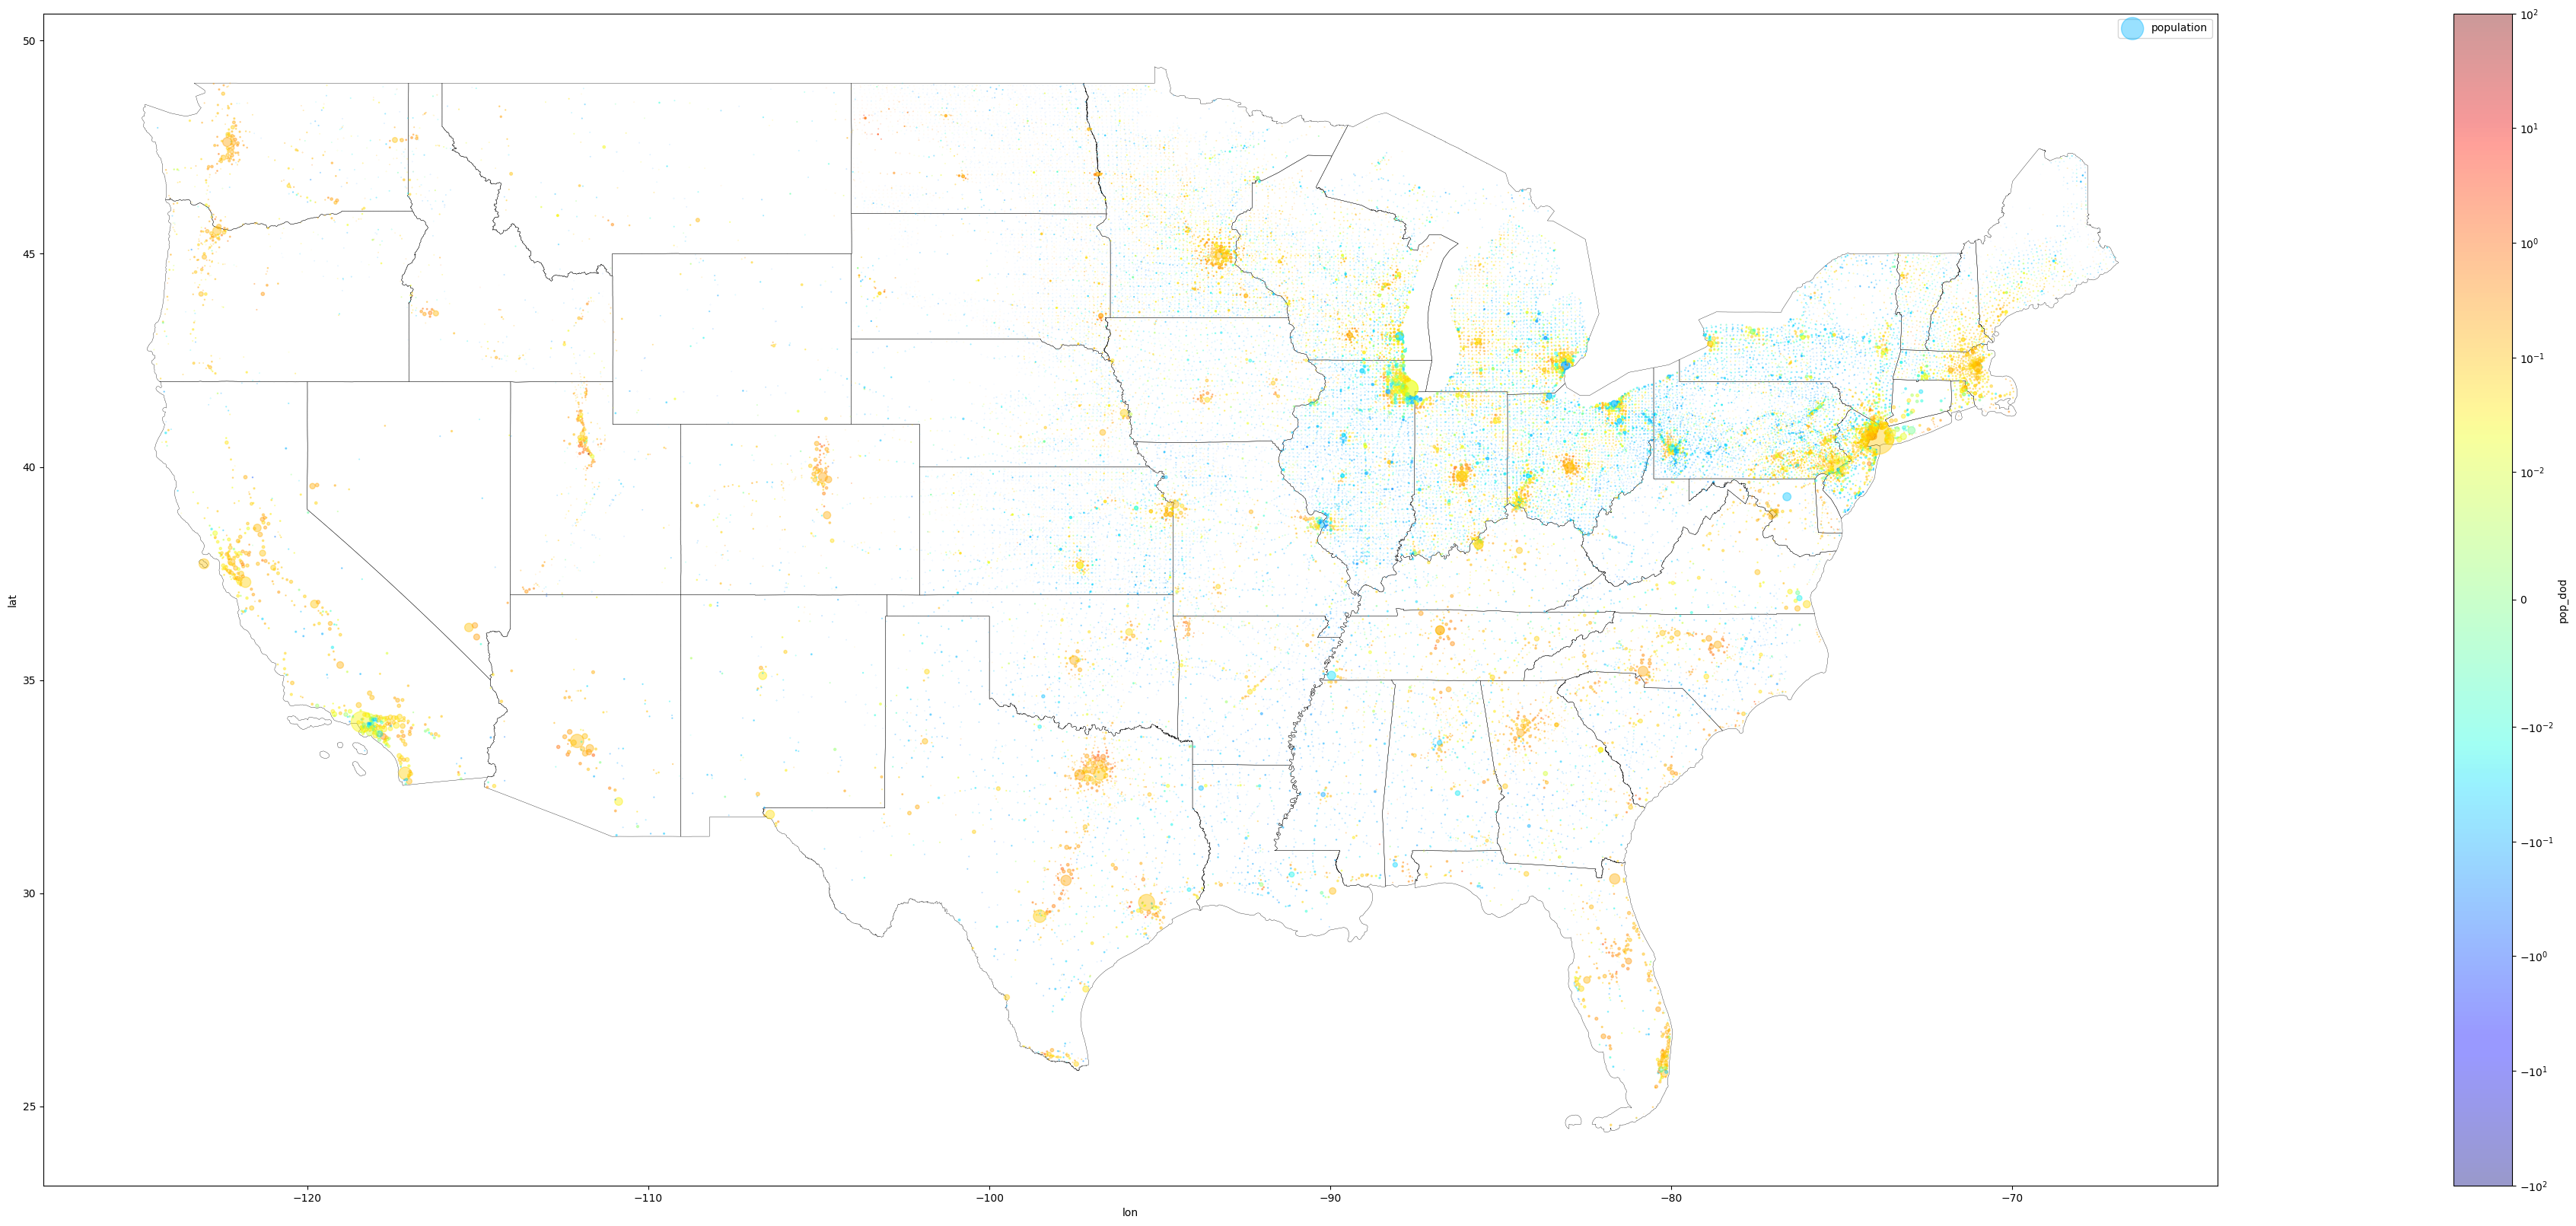

In [19]:
'''
Plot U.S. cities on map.
'''
%matplotlib inline

REGION = CONTINENTAL

# take only continental part of the U.S.
states_map = states[states["usps_abbr"].isin(REGION)]
places_map = places[places["state_abbr"].isin(REGION)].fillna(value={"pop_dod": 0., "pop_ltd": 0.})

fig = plt.figure(0, figsize=(80,20)) 
plot = fig.add_subplot()

states_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="black",
)

places_map.plot(
    ax=plot, zorder=2,
    kind="scatter", x="lon", y="lat", alpha=0.4,
    s=places_map["pop_last"].astype("float64") / 10000, label="population",
    c="pop_dod", cmap="jet", norm=colors.SymLogNorm(linthresh=0.01, vmin=-100, vmax=100, base=10), colorbar=True,
)


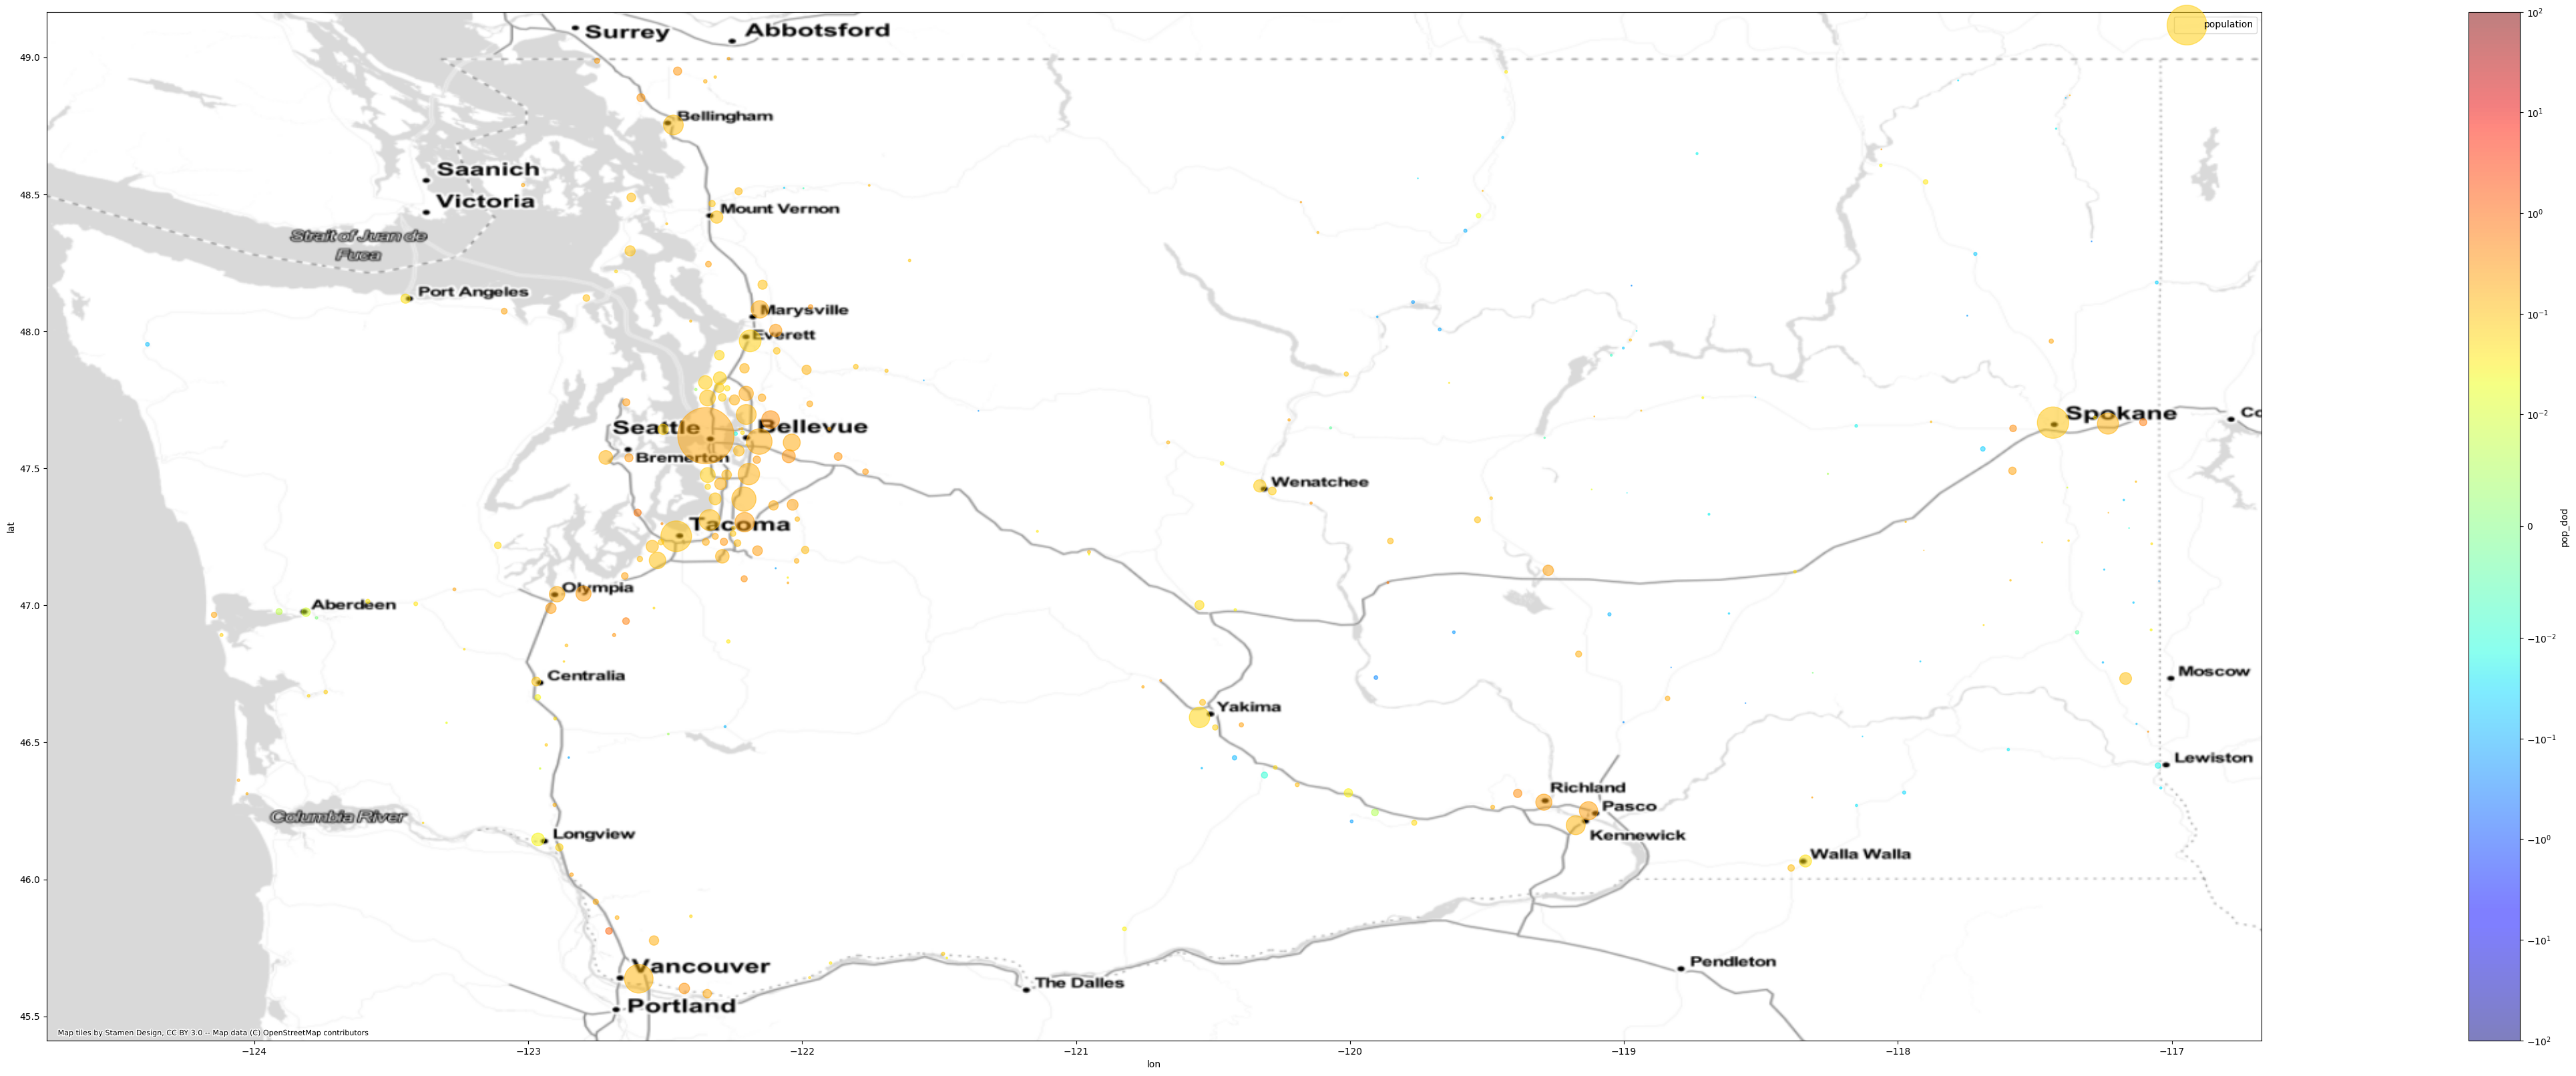

In [20]:
'''
Plot state cities on map.
'''

REGION = ["WA"]

# load places dataframe
#places = gpd.read_file(OUTBOUND_PATH + "/us_cities.shp")

# take only WA state
states_map = states[states["usps_abbr"].isin(REGION)]
places_map = places[places["state_abbr"].isin(REGION)].fillna(value={"pop_dod": 0., "pop_ltd": 0.})

fig = plt.figure(0, figsize=(80, 20)) 
plot = fig.add_subplot()

# states_map.boundary.plot(
#     ax=plot, zorder=1,
#     linewidth=0.25, color="black",
# )

# places_map.plot(
#     ax=plot, zorder=2,
#     linewidth=0.25, color="lightgray",
# )

# places_map.boundary.plot(
#     ax=plot, zorder=2,
#     linewidth=0.25, color="gray",
# )

places_map.plot(
    ax=plot, zorder=3,
    kind="scatter", x="lon", y="lat", alpha=0.5,
    s=places_map["pop_last"].astype("float64") / 200, label="population",
    c="pop_dod", cmap="jet", norm=colors.SymLogNorm(linthresh=0.01, vmin=-100, vmax=100, base=10), colorbar=True,
)

cx.add_basemap(plot, crs=places_map.crs, source=cx.providers.Stamen.TonerLite)